In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)
inspector

In [11]:
# Use inspector to view table details
for table_name in inspector.get_table_names():
    for column in inspector.get_columns(table_name):
        print( table_name,": ", column.get('name'), ", ", column.get('type'))

measurement :  id ,  INTEGER
measurement :  station ,  TEXT
measurement :  date ,  TEXT
measurement :  prcp ,  FLOAT
measurement :  tobs ,  FLOAT
station :  id ,  INTEGER
station :  station ,  TEXT
station :  name ,  TEXT
station :  latitude ,  FLOAT
station :  longitude ,  FLOAT
station :  elevation ,  FLOAT


# Exploratory Climate Analysis

('2017-08-23',)
2016-08-23


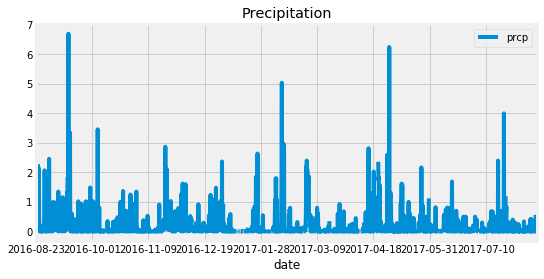

In [26]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
Lastdate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print (Lastdate)


# Perform a query to retrieve the data and precipitation scores
year_ago = dt.date(2017,8,23) - dt.timedelta(days = 365)
print(year_ago)

precipitation = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>=year_ago).order_by(Measurement.date).all()
prcpdata = pd.DataFrame(precipitation)
prcpdata.set_index("date",inplace=True)
prcpdata.head()


# Use Pandas Plotting with Matplotlib to plot the data
ax = prcpdata.plot(figsize=(8,4))
ax.set_title("Precipitation")
plt.show()

![precipitation](Images/precipitation.png)

In [27]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcpdata.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [28]:
# Design a query to show how many stations are available in this dataset?
count_station = session.query(Station).count()
count_station

9

In [29]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations = session.query(Measurement.station,func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
most_common = stations[0][0]
stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [30]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temp = [func.min(Measurement.tobs),
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs)]
tm = session.query(*temp).filter(Measurement.station == most_common).all()
tm

[(54.0, 85.0, 71.66378066378067)]

In [31]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
highest_temp = session.query(Measurement.tobs).filter(Measurement.station==most_common).\
               filter(Measurement.date >= year_ago).order_by(Measurement.date.desc()).all()
highest_temp_df = pd.DataFrame(highest_temp)
highest_temp_df.head()

,tobs
0,79.0
1,76.0
2,76.0
3,77.0
4,77.0


![precipitation](Images/station-histogram.png)

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


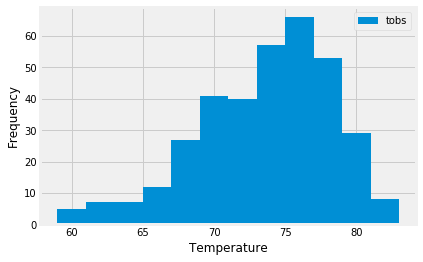

In [32]:
plt.hist(highest_temp_df["tobs"],bins = 12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend(["tobs"], loc="best")

## Optional Challenge Assignment

In [22]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [23]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [24]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [25]:
# Plot the daily normals as an area plot with `stacked=False`
